In [27]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import math
from pprint import pprint
import requests

from datetime import datetime
import itertools
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn import metrics

In [2]:
saas = pd.read_csv('saas.csv')

In [3]:
saas.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
saas['Month_Invoiced'] = pd.to_datetime(saas['Month_Invoiced'])
saas.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [5]:
saas=saas.set_index('Month_Invoiced')

In [6]:
saas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 4 columns):
Customer_Id          790458 non-null int64
Invoice_Id           790458 non-null int64
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
dtypes: float64(2), int64(2)
memory usage: 30.2 MB


Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [7]:
saas_try = saas[['Amount']].resample('D').sum().reset_index()
X = saas_try.Month_Invoiced
y = saas_try.Amount

In [8]:
saas_try.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 2 columns):
Month_Invoiced    1431 non-null datetime64[ns]
Amount            1431 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.4 KB


In [9]:
saas2 = saas[['Amount']].resample('M').sum().reset_index()
X = saas2.Month_Invoiced
y = saas2.Amount

In [10]:
saas2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
Month_Invoiced    48 non-null datetime64[ns]
Amount            48 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 848.0 bytes


In [12]:
saas2=saas2.set_index('Month_Invoiced')

In [13]:
target_var='Amount'
saas2 = saas2[target_var].resample('M').sum()
saas2.head()

Month_Invoiced
2014-01-31    35850.0
2014-02-28    37190.0
2014-03-31    38295.0
2014-04-30    39255.0
2014-05-31    40355.0
Freq: M, Name: Amount, dtype: float64

In [14]:
def split_saas_data(saas2, train_prop=.66): 
    train_size = int(len(saas2) * train_prop)
    train, test = saas2[0:train_size].reset_index(), saas2[train_size:len(saas2)].reset_index()
    return train, test

In [15]:
train, test = split_saas_data(saas2, train_prop=.66)

In [16]:
train.head()

,Month_Invoiced,Amount
0,2014-01-31,35850.0
1,2014-02-28,37190.0
2,2014-03-31,38295.0
3,2014-04-30,39255.0
4,2014-05-31,40355.0


In [17]:
test.head()

,Month_Invoiced,Amount
0,2016-08-31,52940.0
1,2016-09-30,52975.0
2,2016-10-31,53190.0
3,2016-11-30,53375.0
4,2016-12-31,53320.0


In [18]:
test['Month_Invoiced'] = pd.to_datetime(test['Month_Invoiced'])
train['Month_Invoiced'] = pd.to_datetime(train['Month_Invoiced'])

In [19]:
train=train.set_index('Month_Invoiced')
test=test.set_index('Month_Invoiced')

In [20]:
print('Observations: %d' % (len(saas2)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 48
Training Observations: 31
Testing Observations: 17


In [21]:
train.head()

,Amount
Month_Invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


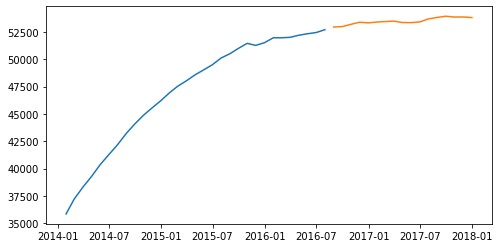

In [22]:
plt.figure(figsize=(8, 4))
plt.plot(train) # we can also run it as: train.plot() and test.plot()
plt.plot(test)
plt.show()

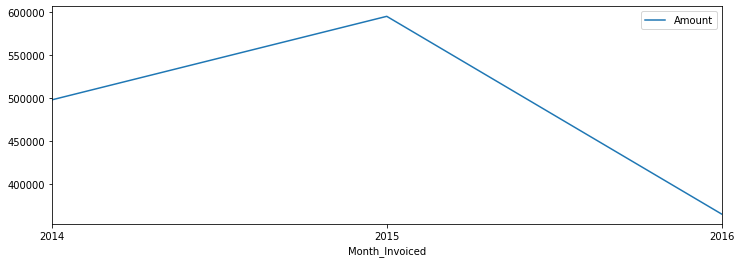

In [23]:
train.resample('Y').sum().plot(figsize=(12, 4))
plt.show()

In [30]:
yhat = pd.DataFrame(test[target_var])

In [31]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_var, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_var) is not list:
        target_var = [target_var]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_var],label='Train', linewidth=1)
    plt.plot(test[target_var], label='Test', linewidth=1)

    for var in target_var:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [32]:
evaluate(target_var, train = train, test = test, output=True)

MSE:  0.0
RMSE: 0.0
